In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
%matplotlib inline

# Adding the dependencies

There are a lot of different pacages out there, but I have to give full credit to the creators of all these packages. The true heros of this analysis has to be pandas, numpy, sklearn, seaborn and matplotlib. These packages allow us to not only work with the tabular data, but also give us the lifting power to develop some models for predictions etc.

In this example, we will start with an exploratory data analysis - followed by a machine learning pipeline - evaluated on the given dataset. For the purpose of these experiments, we will use the Engineering datasets - but any large tabular dataset will do to make this analysis effective.

Let us start by loading the data

In [28]:
educationdata1 = pd.read_csv(*Insert your data here*)

You will not always have the luxary to open your dataset in a data frame, especially when you work with very rarge datasets. As such, we can view a portion of the data to get a sense of what the dataframe looks like.


**Let us look at the first five rows of the data, to have an idea if what is inside the dataset**


In [45]:
educationdata1.head()

,ID,final_result,Female,Male,YoG,SGPA,CGPA100,CGPA200
0,1,Pass,1,0,1.1,3.13,2.88,3.48
1,2,Pass,1,0,1.1,3.02,3.25,4.26
2,3,Pass,0,1,1.1,2.19,1.78,1.98
3,4,Borderline pass,0,1,1.1,3.19,2.67,2.44
4,5,Pass with distinction,1,0,1.1,4.24,3.61,3.69


Simply looking at the first five rows of the data is not always the most effective way to understand what is going on inside the dataset. We can look a bit deeper at the given information to understand what type of variables are within the dataset. 

**In the code below we will do two things, look at the variable types, as well as how many missing datapoints are within the dataset**

This is important is we want to build a machine learning model to evaluate something that predicts student outcomes. More on this a bit later

In [30]:
educationdata1.info()
educationdata1.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3046 entries, 0 to 3045
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   IDNo          3046 non-null   int64  
 1   ID            3046 non-null   int64  
 2   final_result  3046 non-null   object 
 3   Female        3046 non-null   int64  
 4   Male          3046 non-null   int64  
 5   YoG           3046 non-null   float64
 6   SGPA          3046 non-null   float64
 7   CGPA100       3046 non-null   float64
 8   CGPA200       3046 non-null   float64
 9   CGPA300       3046 non-null   float64
dtypes: float64(5), int64(4), object(1)
memory usage: 238.1+ KB


IDNo            0
ID              0
final_result    0
Female          0
Male            0
YoG             0
SGPA            0
CGPA100         0
CGPA200         0
CGPA300         0
dtype: int64

This is great! We can see that the intiger variables are within IDNo, ID and the "Male" and "Female" variables. This makes sense since one-hot-encoding was used to stratify the categorical "Male and Female" variables. We can also observe that "final_result" is an object variable. THis makes sense since there are four categories within the "final_result" variable:
- Pass
- Piss with distinction
- Borderline pass
- Fail


These for categories will be what we predict in our machine learning model down the line.

**Next, let us get a sense for the central tendencies of the data by looking at the descriptive statistics**

In [46]:
summary = educationdata1.describe()
summary = summary.transpose()
summary

,count,mean,std,min,25%,50%,75%,max
ID,3046.0,1523.500000,879.448786,1.00,762.25,1523.50,2284.75,3046.00
Female,3046.0,0.358831,0.479736,0.00,0.00,0.00,1.00,1.00
Male,3046.0,0.641169,0.479736,0.00,0.00,1.00,1.00,1.00
YoG,3046.0,1.318385,0.132910,1.10,1.20,1.30,1.40,1.50
SGPA,3046.0,3.119645,0.616151,1.46,2.66,3.06,3.57,4.93
CGPA100,3046.0,3.636106,0.679256,1.57,3.18,3.69,4.15,5.00
CGPA200,3046.0,3.321687,0.782473,1.17,2.76,3.34,3.92,5.00


This is quite insightful, 64.11% of the sample is male, and 35.88% female.The average GPA (grade point average) decrease from the first to the final year (on average, but there are exceptions) and there were people with a perfect GPA in their first and second year of study.

We could not work out the descriptive statistics on the categorical variable "final_result", so let us investigate this with a bit more detail by counting each of these.

In [32]:
count = educationdata1.final_result.value_counts()
count

Pass                     1659
Pass with distinction    1085
Borderline pass           298
Fail                        4
Name: final_result, dtype: int64

Interesting find, only 4 people failed within this dataset and the majority (n = 1659) passed this module. Next, let us look at the associations between variable pairs in the sample by looking at the Pearson's correlation coefficients between pairs of variables in the example

In [33]:
educationdata1.drop(educationdata1.columns[[-1, 0]], axis=1, inplace=True)

In [34]:
educationdata1_corr = educationdata1.corr()
educationdata1_corr

,ID,Female,Male,YoG,SGPA,CGPA100,CGPA200
ID,1.000000,-0.228863,0.228863,0.098514,0.076069,0.183832,0.005244
Female,-0.228863,1.000000,-1.000000,-0.005122,0.023773,-0.016260,0.197654
Male,0.228863,-1.000000,1.000000,0.005122,-0.023773,0.016260,-0.197654
YoG,0.098514,-0.005122,0.005122,1.000000,-0.088181,0.100879,-0.091117
SGPA,0.076069,0.023773,-0.023773,-0.088181,1.000000,0.434993,0.344725
CGPA100,0.183832,-0.016260,0.016260,0.100879,0.434993,1.000000,0.703889
CGPA200,0.005244,0.197654,-0.197654,-0.091117,0.344725,0.703889,1.000000


Not surprising, male and female are inversely proportional to one another. This is expected since one-hot-encoding was used on this categorical variable to quantify the category. A few interesting associations can be seen in the data:

- The association between year **one GPA100 and year two GPA200**. This is interesting as there is an association shawing that academic success within the first year of study does translate to the second.
- The association between **School leaver GPA (SGPA) and GPA100**. What must be noted is that this association goes down as the student progresses through university - in other words, the School GPA has a higher impact on the first year of study, than any other year of study.

To better visualise this table, we can display the results in a **heatmap**. A heatmap visually illustrates this relationship by using colours so that the results can be interpreted visually using colour gradients as well. 

**While we are at it, let us also visualise the "final_result" variable to look at the distribution of the categories.**

(Text(0.5, 1.0, 'Student outcomes'),
 Text(0.5, 0, 'Outcome'),
 Text(0, 0.5, 'Number of students'))

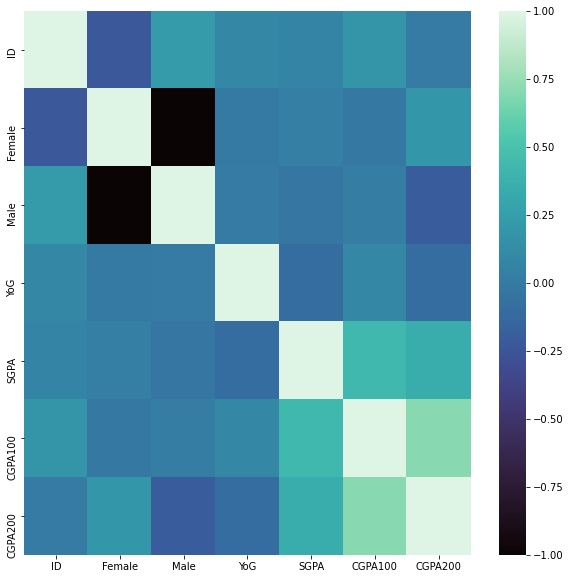

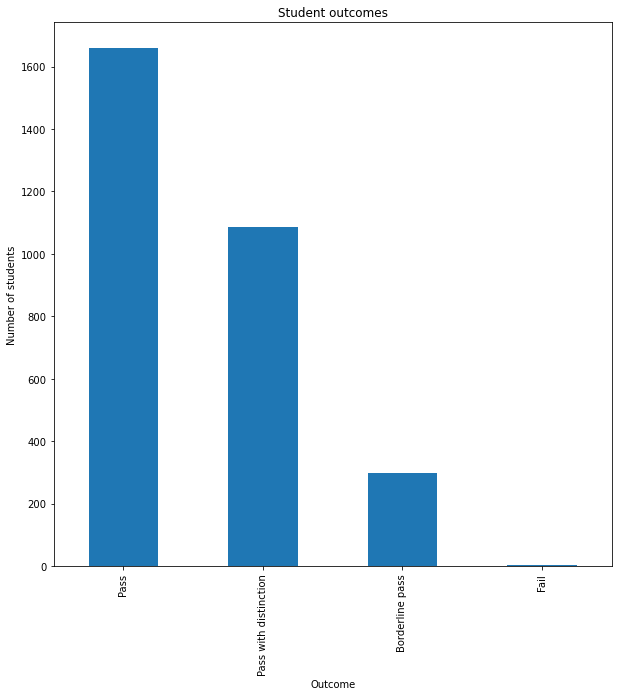

In [35]:
f,ax = plt. subplots(figsize = (10,10))
sns.heatmap(educationdata1_corr, annot = False, cmap="mako")
f,ax = plt. subplots(figsize = (10,10))
count.plot.bar()
plt.title('Student outcomes'),plt.xlabel('Outcome'),plt.ylabel('Number of students')

## Importing the datasets for machine learning

Now that we managed to verify that there are only numerical variables, except for the target variable ("final_result") and that we have no missing values in the data, let us build a machine learning classification algorithm to predict the likelyhood of a falling into one of these four categories. There are multiple techniques we can use to improve the model - but for the purpose of this experiment, we will not focus too much on fine tuning the model for this specific dataset.

**Firstly, we need to set the parameters for the model**

In [36]:
x1 = educationdata1.drop("final_result", axis = 1)
y1 = educationdata1.final_result
x2 = educationdata1.drop("final_result", axis = 1)
y2 = educationdata1.final_result
x_train = x1
y_train = y1
x_test = x1
y_test = y1

## Split the data into their respective parts and run the first algorithm

We will make use of the train/test method to valdate the model. The intuition of this method is that if you have a large enough dataset, then you can use the dataset itself to train and test the model.

**in other words**, if I have 2500 samples, I can use 500 sample to train the model - and then use the remainding 2000 to test the model. Since I **Know the results of the 2000 samples** I can see how well the model performed at predicting the outcome.

For this illustration, we will use one technique of both evaluating and testing the model. In the first instance, we will use a k-Nearest Neighbor algorithm. This part of the tutorial is not to teach you how these work, or even to explain the complexities within the code - but merely to expose you into how the exploratory data analysis from earlier can help inform the type of models we build.

### Let us start with kNN, and visualse it using a learning curve

In [44]:
kNN = KNeighborsClassifier(n_neighbors=18)

C:\Users\Combrinkhm\Anaconda3\envs\BNLEARN\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


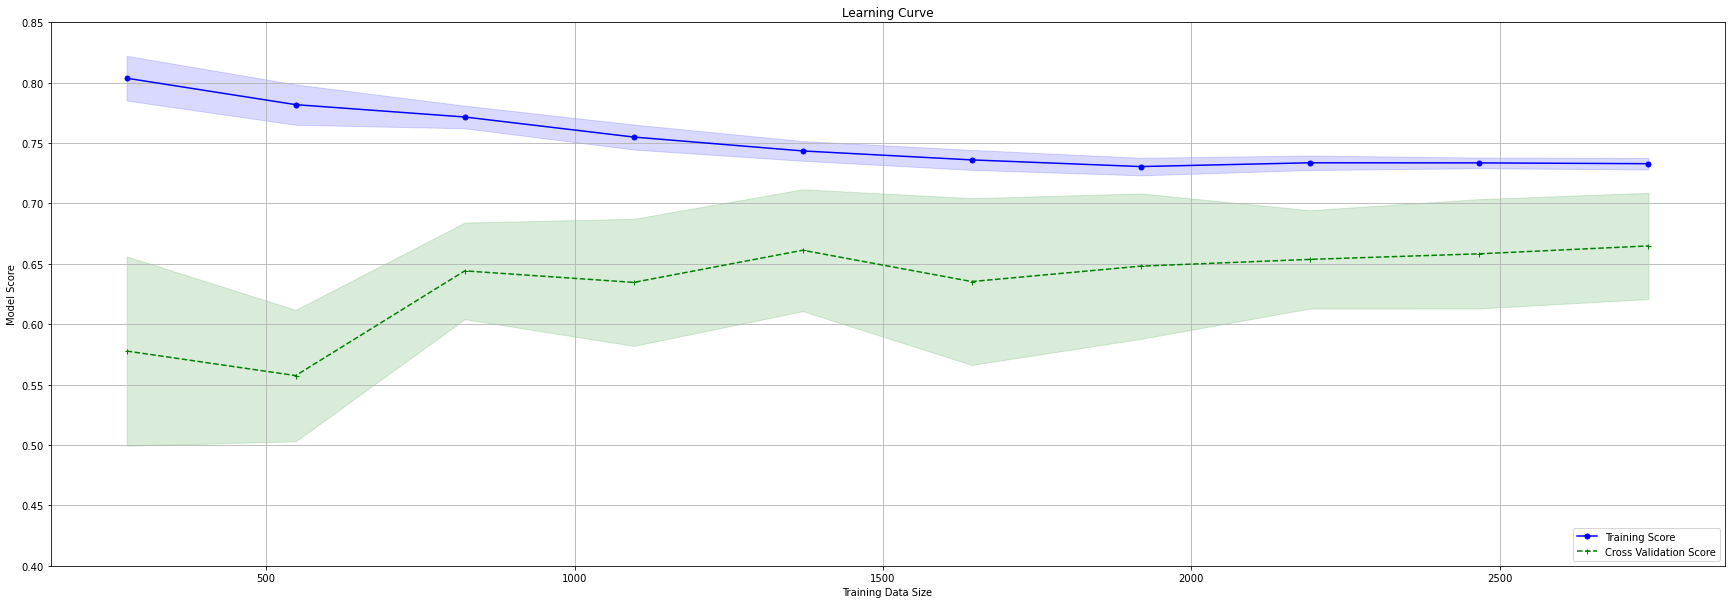

In [47]:
pipeline = make_pipeline(StandardScaler(), kNN)

train_sizes, train_scores, test_scores = learning_curve(estimator = pipeline, X=x_train, y=y_train,
                                                       cv=10, train_sizes=np.linspace(0.1,1,10),
                                                     n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

ax = plt.figure(figsize=[30,10])

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Score')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Cross Validation Score')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model Score')
plt.grid()
plt.ylim(0.4, 0.85)
plt.legend(loc='lower right')
plt.show()

**I know there is a lot going on, but if this is your first time, keep the followin in mind**

- You are looking at a graph that should be viewed like a time series analysis, from left to right
- The X axis represents the training data size - that is, the number of sample that is used to predict the outcome
- The Y axis depicts the "model score" or accuracy. This score is calculated using a variery of different metrics in what is know as a confusion matrix. This type of scoring is not ideal by itself as it leaves out the number of false positives/negatives/ over and underfitting issues in the data - but at the very least, it is a method for evaluating a model superficially. 

Another important takehome from this model is that the overall accuracy tends to deviate between roughly 60%-70%. This means that the model itself is not perfect yet. One observation that can be made is that the cross validation score and the Training score get closer and closer the more training data is added to the model. This means that for this prediction to be effective, at least 6000 more samples are needed. 

Another important factor to note is that this model is built on an engineering cohort that used GPA, and might not be applicable to all education contexts. However, what this type of thinking should expose you too is that you can use data and code to gain the required insight from your cohort to build models like this to better understand your context. 